# NMF for music transcription 

In [58]:
%matplotlib inline
from pathlib import Path
import numpy as np, scipy, matplotlib.pyplot as plt, sklearn, urllib, IPython.display as ipd
import librosa, librosa.display

Nonnegative matrix factorization (NMF) is an algorithm that factorizes a nonnegative matrix, $X$, into a product of two nonnegative matrices, $W$ and $H$. It is an unsupervised iterative algorithm that minimizes a distance between $X$ and the product $WH$:

$$ \min_{W, H} d(X, WH) $$

If $X$ has dimensions $M$ by $N$, then $W$ will have dimensions $M$ by $R$, and $H$ will have dimensions $R$ by $N$, where inner dimension $R$ is the *rank* or *number of components* of the decomposition.

When applied to a musical signal, we find that NMF can decompose the signal into separate note events. Therefore, NMF is quite useful and popular for tasks such as transcription and source separation.

The input, $X$, is often a magnitude spectrogram. In such a case, we find that the columns of $W$ represent spectra of note events, and the rows of $H$ represent temporal envelopes of the same note events.

## 251 in C Major

In [59]:
x, sr = librosa.load('left_hand_major_251.wav')

In [60]:
ipd.Audio(x, rate=sr)

Compute the STFT:

In [61]:
# stft with default hop length and window size 
# hop length = 512
S = librosa.stft(x)

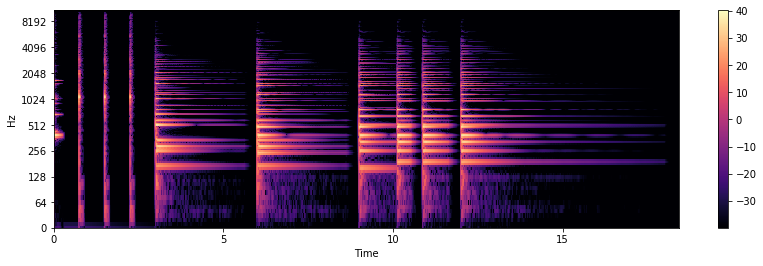

In [62]:
S_db = librosa.amplitude_to_db(abs(S))
plt.figure(figsize=(14, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

## Decompose into harmonic and percussive parts of the STFT

In [63]:
# decompose the harmonic and percussive parts 
S_harmonic, S_percussive = librosa.decompose.hpss(S)

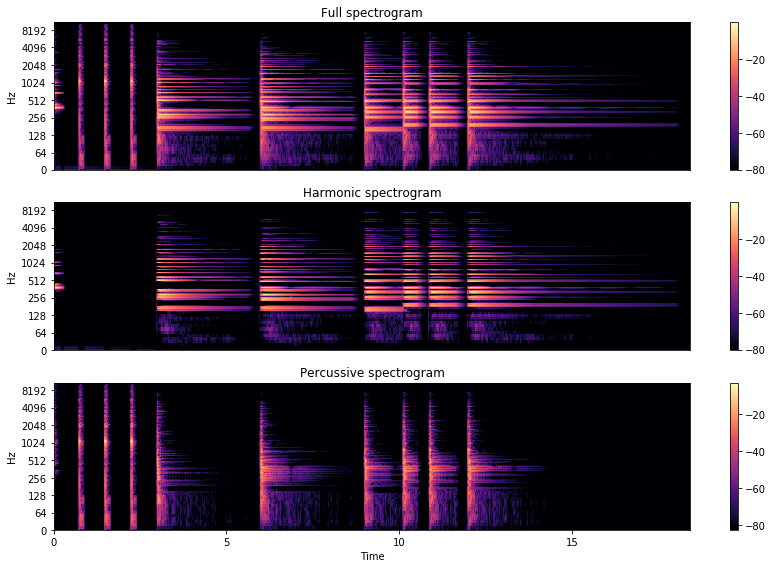

In [64]:
# Pre-compute a global reference power from the input spectrum
rp = np.max(np.abs(S))

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(S), ref=rp), y_axis='log')
plt.colorbar()
plt.title('Full spectrogram')

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(S_harmonic), ref=rp), y_axis='log')
plt.colorbar()
plt.title('Harmonic spectrogram')

plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(S_percussive), ref=rp), y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Percussive spectrogram')
plt.tight_layout()

### NMF decomposition

NMF extracts unique events 

In [65]:
# seperate the harmonic STFT into magnitude and phase
X, X_phase = librosa.magphase(S_harmonic)

# Here we set n_components to 3
n_components = 3
# NMF decomposition 
W, H = librosa.decompose.decompose(X, n_components=n_components, sort=True)

print(W.shape)
print(H.shape)

(1025, 3)
(3, 793)


Let's display the spectral profiles:

C:\Users\olli\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


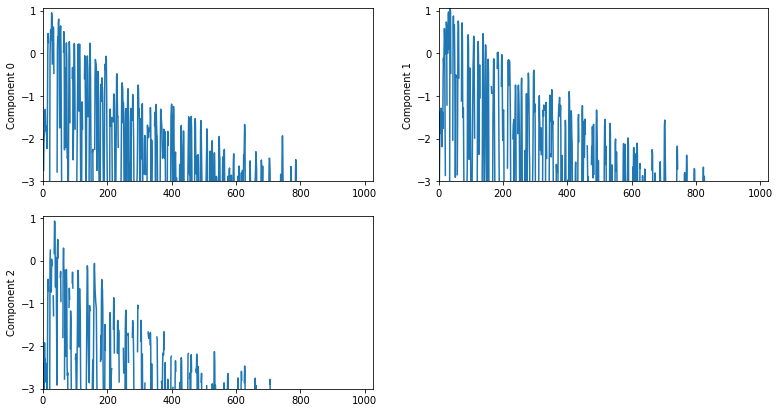

In [66]:
plt.figure(figsize=(13, 7))
logW = np.log10(W)
for n in range(n_components):
    plt.subplot(np.ceil(n_components/2.0), 2, n+1)
    plt.plot(logW[:,n])
    plt.ylim(-3, logW.max())
    plt.xlim(0, W.shape[0])
    plt.ylabel('Component %d' % n)

# Find the frequency of the components ? 

The components are simply DFT representations of each note that has been played

In [67]:
from __future__ import division

def parabolic(f, x):
    """Quadratic interpolation for estimating the true position of an
    inter-sample maximum when nearby samples are known.
    """
    # Requires real division.  Insert float() somewhere to force it?
    xv = 1/2 * (f[x-1] - f[x+1]) / (f[x-1] - 2 * f[x] + f[x+1]) + x
    yv = f[x] - 1/4 * (f[x-1] - f[x+1]) * (xv - x)
    return (xv, yv)

In [68]:
def freq_from_dft(dft):
    i = np.argmax(abs(dft))
    true_i = parabolic(np.log(dft),i)[0]
    return sr*true_i/len(dft)

In [69]:
# find the fundamental frequency of each component using parabolic interpolation 

for n in range(n_components):
    
    freq_est = freq_from_dft(W[:,n])
    print('component ', n, ': ',freq_est, 'Hz')

component  0 :  588.2407898190074 Hz
component  1 :  782.9839142019174 Hz
component  2 :  784.3674379309759 Hz


C:\Users\olli\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


Let's display the temporal activations, $\{h_1, ..., h_R\}$:

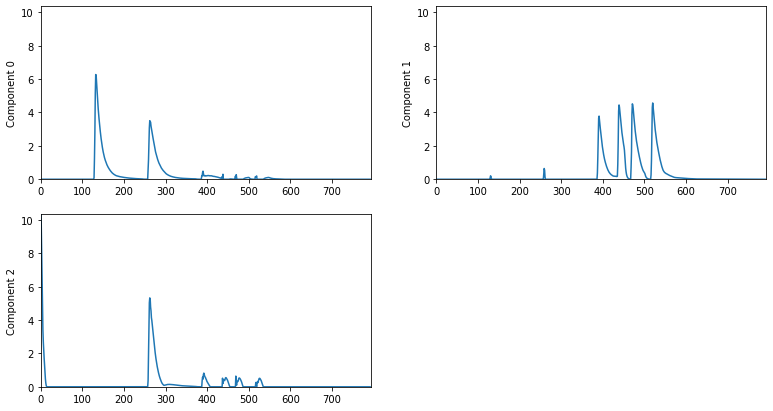

In [70]:
plt.figure(figsize=(13, 7))
for n in range(n_components):
    plt.subplot(np.ceil(n_components/2.0), 2, n+1)
    plt.plot(H[n])
    plt.ylim(0, H.max())
    plt.xlim(0, H.shape[1])
    plt.ylabel('Component %d' % n)

Re-create the individual components, and listen to them. 

In [71]:
for n in range(n_components):
    
    # Re-create the STFT of a single NMF component.
    Y = scipy.outer(W[:,n], H[n])*X_phase
    
    # Transform the STFT into the time domain.
    y = librosa.istft(Y)
    
    print('Component {}:'.format(n))
    ipd.display( ipd.Audio(y, rate=sr) )

Component 0:


Component 1:


Component 2:


Listen to the reconstructed full mix:

In [72]:
# Re-create the STFT from all NMF components.
Y = np.dot(W, H)*X_phase

# Transform the STFT into the time domain.
reconstructed_signal = librosa.istft(Y, length=len(x))
ipd.Audio(reconstructed_signal, rate=sr)

Listen to the residual:

In [73]:
residual = x - reconstructed_signal
residual[0] = 1 # hack to prevent automatic gain scaling
ipd.Audio(residual, rate=sr)